In [1]:
%run -m ipy_startup
%run -m ipy_logging
%matplotlib inline
%load_ext rpy2.ipython
from musc_genomics.data_import import cgds, api, prep
from musc_genomics.data_modeling import modeling
from musc_genomics import data
pd.set_option('max_info_rows', int(1E9))

# Load Cosmic Response Data

In [2]:
d_cosmic = data.load('prepared', 'response_cosmic')
d_cosmic.info()

2016-07-17 07:36:09,851:DEBUG:research.project.manager: Loading saved data from location "/Users/eczech/data/research/musc_genomics/prepared/response_cosmic.pkl"


<class 'pandas.core.frame.DataFrame'>
Int64Index: 958836 entries, 0 to 1187759
Data columns (total 8 columns):
CellLine             958836 non-null object
CosmicID             958836 non-null int64
CancerType           958836 non-null object
Tissue               958836 non-null object
ExperimentDetails    958836 non-null object
Value                958836 non-null float64
DrugName             958836 non-null object
ValueUnit            958836 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 65.8+ MB


# Load CGDS Features

In [3]:
d_cgds = data.load('prepared', 'features_raw_sparse')
d_cgds.iloc[:5, :10]

2016-07-17 07:36:11,300:DEBUG:research.project.manager: Loading saved data from location "/Users/eczech/data/research/musc_genomics/prepared/features_raw_sparse.pkl"


FEATURE,CN:A1BG,CN:A1BG-AS1,CN:A1CF,CN:A2M,CN:A2ML1,CN:A4GALT,CN:A4GNT,CN:AAAS,CN:AACS,CN:AACSP1
TUMOR_ID,,,,,,,,,,
1321N1,-0.15440,-0.15440,-0.09850,-0.1819,-0.1819,-0.1732,0.25750,-0.04040,-0.1284,0.1682
143B,-0.21200,-0.21200,0.15800,-0.1753,-0.1753,-0.2536,0.20600,-0.14450,-0.2757,0.2150
22RV1,-0.08084,-0.08084,-0.00250,0.4486,0.4486,-0.0574,-0.03030,0.46490,0.4406,-0.0518
2313287,-0.03310,-0.03310,-0.05348,-0.1917,-0.1917,-0.0512,-0.04608,-0.01474,-0.0516,-0.0514
253JBV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
d_cgds.filter(regex='MU:').iloc[:5, :15]

FEATURE,MU:AAC:AAK1:F312Lfs*26,MU:AAC:AAK1:G15D,MU:AAC:AAK1:H189R,MU:AAC:AAK1:N713S,MU:AAC:AAK1:P336T,MU:AAC:AAK1:P461S,MU:AAC:AAK1:P771R,MU:AAC:AAK1:Q533H,MU:AAC:AAK1:Q545_Q546del,MU:AAC:AAK1:Q743*,MU:AAC:AAK1:R634C,MU:AAC:AAK1:R634H,MU:AAC:AAK1:R843G,MU:AAC:AAK1:T885Hfs*9,MU:AAC:AAK1:V611A
TUMOR_ID,,,,,,,,,,,,,,,
1321N1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22RV1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2313287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253JBV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
d_cgds.filter(regex='^GE:').apply(pd.isnull).mean(axis=1).value_counts()

0.0    967
1.0     52
dtype: int64

In [6]:
d_cgds.filter(regex='^MU:AAC').apply(pd.isnull).mean(axis=1).pipe(pd.cut, bins=10).value_counts()

(0.997, 1]        946
(0.994, 0.997]     44
(0.992, 0.994]     12
(0.986, 0.989]      5
(0.989, 0.992]      4
(0.981, 0.983]      3
(0.983, 0.986]      2
(0.978, 0.981]      1
(0.975, 0.978]      1
(0.972, 0.975]      1
dtype: int64

# Merge

In [7]:
# This list should contain all drugs to undergo further study (it 
# should grow over time, and not be repeated in different scenarios
# and saved to multiple merged results)
drug_names = [
    'PD-0332991', # Palbociclib
    'ABT-263', # Navitoclax
    'SB590885', 'PLX4720', 'Nutlin-3a', 'AZD2281', 'AG-014699'
]

d = modeling.get_modeling_data(d_cosmic, d_cgds, drug_names)
d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 22RV1 to ZR7530
Columns: 107384 entries, CN:A1BG to RES:VAL:SB590885
dtypes: float64(107378), object(6)
memory usage: 342.5+ MB


In [8]:
d.filter(regex='RES:').info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 22RV1 to ZR7530
Data columns (total 8 columns):
RES:CANCERTYPE        418 non-null object
RES:TISSUE            418 non-null object
RES:VAL:ABT-263       413 non-null float64
RES:VAL:AG-014699     411 non-null float64
RES:VAL:NUTLIN-3A     413 non-null float64
RES:VAL:PD-0332991    391 non-null float64
RES:VAL:PLX4720       413 non-null float64
RES:VAL:SB590885      398 non-null float64
dtypes: float64(6), object(2)
memory usage: 29.4+ KB


# Export

In [9]:
data.save('prepared', 'modeling_data_merge_raw', d)

2016-07-17 07:40:09,591:DEBUG:research.project.manager: Saving data to location "/Users/eczech/data/research/musc_genomics/prepared/modeling_data_merge_raw.pkl"


'/Users/eczech/data/research/musc_genomics/prepared/modeling_data_merge_raw.pkl'

# Analysis

In [45]:
d.filter(regex='^RES:|^CL:').head()

FEATURE,CL:CANCER_TYPE,CL:HISTOLOGY,CL:PRIMARY_SITE,CL:GENDER,RES:CANCERTYPE,RES:TISSUE,RES:VAL:NUTLIN-3A,RES:VAL:PD-0332991,RES:VAL:PLX4720,RES:VAL:SB590885
TUMOR_ID,,,,,,,,,,
22RV1,solid,carcinoma,prostate,male,urogenital_system,prostate,2.549906,0.517856,6.697773,4.639378
2313287,solid,carcinoma,stomach,male,digestive_system,stomach,3.039341,3.912658,6.753041,6.373648
5637,solid,carcinoma,urinary_tract,male,urogenital_system,bladder,6.412843,5.887130,2.998122,5.108025
639V,solid,carcinoma,urinary_tract,male,urogenital_system,bladder,3.779543,3.054728,6.816524,6.274532
647V,solid,carcinoma,urinary_tract,male,urogenital_system,bladder,6.739784,5.881208,6.842532,6.625275


In [48]:
d[(d['CL:PRIMARY_SITE'] == 'skin') & (d['RES:TISSUE'] == 'large_intestine')].iloc[:5, :5]

FEATURE,CN:A1BG,CN:A1BG-AS1,CN:A1CF,CN:A2M,CN:A2ML1
TUMOR_ID,,,,,
COLO741,-0.8174,-0.8174,-0.2233,0.0218,0.0218


In [46]:
d.groupby(['CL:PRIMARY_SITE', 'RES:TISSUE']).size()

CL:PRIMARY_SITE                     RES:TISSUE                        
autonomic_ganglia                   neuroblastoma                          9
bone                                bone_other                             1
                                    ewings_sarcoma                         1
                                    osteosarcoma                           3
                                    rhabdomyosarcoma                       1
breast                              breast                                34
central_nervous_system              glioma                                25
                                    medulloblastoma                        2
endometrium                         endometrium                            9
haematopoietic_and_lymphoid_tissue  acute_myeloid_leukaemia               10
                                    anaplastic_large_cell_lymphoma         1
                                    b_cell_leukemia                        3
     

In [108]:
dt_mu = d.filter(regex='MU:AAC:{}:'.format(gene_name))
#print(dt_mu.columns.tolist())
dt_mu = dt_mu.sum(axis=1)
dt_mu = (dt_mu / dt_mu).fillna(0)
dt_mu.name = 'MU:Exists'

dt_re = d['RES:Value']
dt = pd.concat([dt_mu, dt_re], axis=1).reset_index()
dt.head()

,TUMOR_ID,MU:Exists,RES:Value
0,22RV1,1.0,2.549906
1,2313287,0.0,3.039341
2,5637,1.0,6.412843
3,639V,1.0,3.779543
4,647V,1.0,6.739784


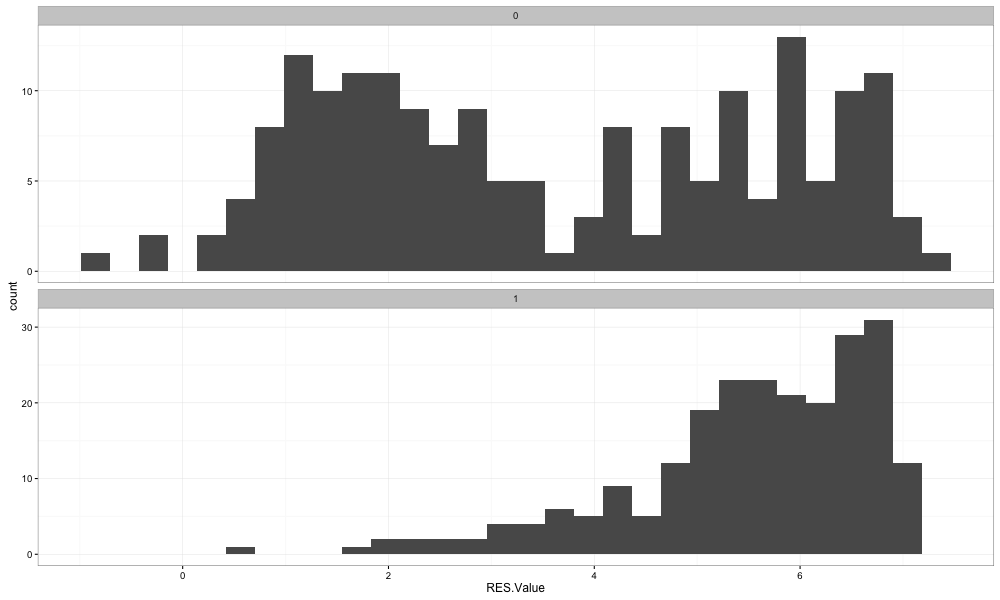

In [109]:
%%R -i dt -w 1000 -h 600 -u px
library(dplyr)
library(ggplot2)

dt %>% ggplot(aes(x=RES.Value)) + geom_histogram(bins=30) + 
    facet_wrap(~MU.Exists, scales='free_y', nrow=2) + theme_bw()